# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Построить модель с предельно большим значением *F1*-меры. Нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

**Установим библиотеки, которые нам могут понадобиться**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    f1_score, 
    roc_curve, 
    roc_auc_score, 
    accuracy_score, 
    confusion_matrix, 
    recall_score, 
    precision_score
)
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from sklearn import tree

import warnings
warnings.filterwarnings("ignore")

Теперь загрузим датасет и посмотрим общую информацию о нем

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('/datasets/Churn.csv')

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None
-------------------------------------------


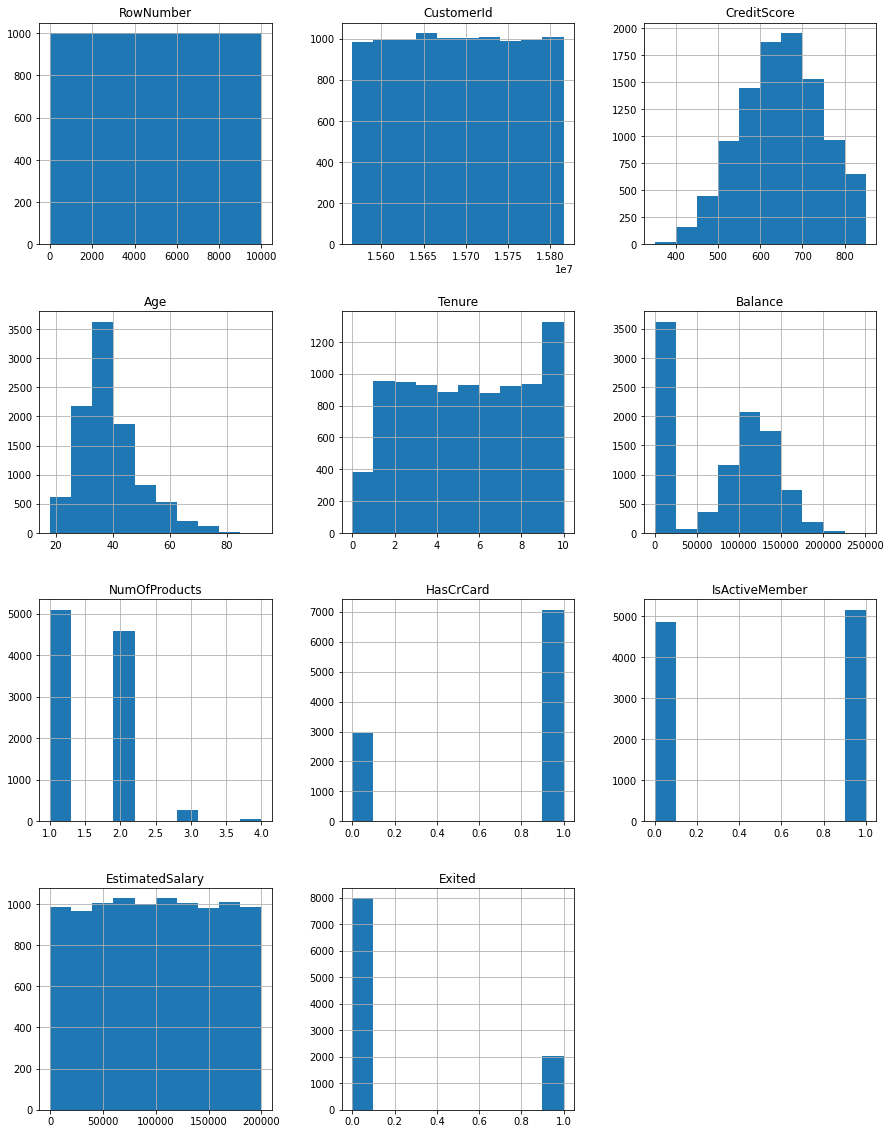

In [3]:
def show_info(df_name):  # создадим функцию, которая покажет всю общую информацию о датасете
    display(df.head(10))
    print('-------------------------------------------')
    print(df.info())
    print('-------------------------------------------')
    df.hist(figsize=(15, 20));
        
show_info(df)

Итак, перед нами данные из 10000 строк и 14 столбцов. Мы видим, что в столбце `Tenure`  (сколько лет человек является клиентом банка) есть пропуски. Типы данных указаны корректно. А на графиках мы видим распределение признаков. Например, целевой признак `Exited` (факт ухода клиента) имеет значительный разброс в классах (8 тысяч значений против 2-х). Дисбалан в целевом признаке мы ликвидируем позже, а пока подготовим данные к исследованию.

In [4]:
# проверим данные на дубликаты
df.duplicated().sum()

0

In [5]:
# заполним пропуски нулевыми значениями
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())

In [7]:
df.info() # убедимся, что пропущенные значения исчесли

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Обратим внимание на первые три столбца: `RowNumber`, `CustomerId`, `Surname`. Эти столбцы не представляют особой ценности для нашего исследования, т.к. по сути являются идентификаторами. В частности столбец `Surname` с фимилями может серьезно усложнить проведение исследования и построения моделей, когда мы начнем переводить категориальные значения в числовые. Поэтому предлагается их просто удалить.

In [8]:
df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])
display(df.head(5))

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [9]:
df.shape

(10000, 11)

In [10]:
# с помощью ОНЕ переведем категориальные значения в числовые
df = pd.get_dummies(df, drop_first=True)
df.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [11]:
df.shape

(10000, 12)

**Вывод:** Для проведения исследования мы подготовили датасет, заполнив пропуски, перобразовав категориальные значения в числовые и удалив не нужные столбцы. Данные в датасете не имеют дубликатов, имеют правильные типы, и мы можем приступать к исследованию.

## Исследование задачи

Как мы отмечали ранее у целевого признака есть значительный разброс в классах. Но для начала попробуем построить модели без учета дисбаланса. И посмотреть на ключевые метрики.

In [12]:
# выделим в данных целевой признак, с которым будем сравнивать, и остальные признаки, на которых мы будем учить модель
features = df.drop('Exited', axis=1)
target = df['Exited']

Поскольку у нас нет тестовой выборки, то создадим её разделив данные в соотношении 3:1:1 на обучающую, валидационную и тестовую выборки соответственно.

In [13]:
# сначала создадим обучающую и валидационную выборки
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state=25)

In [14]:
# теперь из валидационной выделим половину для тестовой выборки
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=25)

In [15]:
# проверим размеры выборок
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(6000, 11)
(6000,)
(2000, 11)
(2000,)
(2000, 11)
(2000,)


Согласно принятым правилам нам удалось разбить общие данные на обучающую, валидационную и тестовую выборки. Размер выборок пропорционален отношению 3:1:1 

In [16]:
# взглянем на тренировочные признаки, чтобы оценить необходимость масштабирования
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
2108,593,74,5.0,161434.36,2,1,1,65532.17,1,0,1
1250,548,32,5.0,175214.71,1,1,1,155165.61,1,0,1
141,663,34,7.0,0.00,2,1,1,180427.24,0,0,1
7512,641,50,6.0,153590.73,2,1,1,130910.78,0,0,1
8875,702,36,9.0,90560.48,2,1,0,174268.87,1,0,1


In [17]:
# для масштабирования зафиксируем численные признаки
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [18]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

In [19]:
# масштабируем числовые признаки обучающей выборки
features_train[numeric] = scaler.transform(features_train[numeric])
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
2108,-0.592534,3.307191,0.004280,1.358667,0.828087,1,1,-0.609150,1,0,1
1250,-1.060596,-0.664294,0.004280,1.579739,-0.891125,1,1,0.960697,1,0,1
141,0.135563,-0.475176,0.727664,-1.231157,0.828087,1,1,1.403131,0,0,1
7512,-0.093267,1.037771,0.365972,1.232835,0.828087,1,1,0.535896,0,0,1
8875,0.541217,-0.286057,1.451048,0.221667,0.828087,1,0,1.295273,1,0,1


In [20]:
# масштабируем числовые признаки валидационной выборки 
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_valid.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
6966,0.135563,-1.609886,0.365972,-1.231157,0.828087,0,1,0.551946,0,0,1
6568,0.770047,1.416008,1.089356,1.531255,-0.891125,1,1,0.640827,1,0,1
7959,-0.977384,0.092179,1.089356,-1.231157,0.828087,1,0,-0.669039,0,0,0
193,-0.509323,-0.664294,1.089356,0.261010,-0.891125,1,0,-0.233906,0,0,1
7618,-0.748554,0.092179,0.727664,-1.231157,0.828087,0,0,0.033644,0,0,0


In [21]:
# масштабируем числовые признаки тестовой выборки 
features_test[numeric] = scaler.transform(features_test[numeric])
features_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7822,-0.717350,1.037771,-1.080796,1.076235,0.828087,1,0,1.417090,1,0,1
8128,0.468407,-0.002380,-0.357412,-0.180028,-0.891125,1,1,-1.735098,0,1,1
2654,-1.227018,0.470416,0.004280,1.152699,-0.891125,1,0,-0.446156,0,0,1
6619,-0.030859,-0.664294,0.004280,0.325634,-0.891125,1,1,-1.351737,0,0,1
8382,-0.530125,-1.326208,0.004280,-1.231157,0.828087,1,1,0.358640,0,1,1


Масштабирование выборок завершено. Теперь мы можем приступить к постоению моделей.

### "Дерево решений" (Decision Tree Classifier)

In [22]:
%%time

best_model1 = None
best_depth1 = 0
accuracy1 = 0
f1_1 = 0
for depth in range(1, 20):
    model_tree = DecisionTreeClassifier(random_state=25, max_depth=depth)
    model_tree.fit(features_train, target_train)
    predictions_valid_tree = model_tree.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions_valid_tree)
    f1 = f1_score(target_valid, predictions_valid_tree)
    if f1 > f1_1:
        best_model1 = model_tree
        accuracy1 = accuracy
        best_depth1 = depth 
        f1_1 = f1

CPU times: user 475 ms, sys: 0 ns, total: 475 ms
Wall time: 473 ms


In [23]:
print('Модель:', best_model1)
print('Лучшая глубина дерева:', best_depth1)
print('Общая точность модели:', accuracy1)
print('Лучшая F1:', f1_1)

Модель: DecisionTreeClassifier(max_depth=7, random_state=25)
Лучшая глубина дерева: 7
Общая точность модели: 0.868
Лучшая F1: 0.5938461538461538


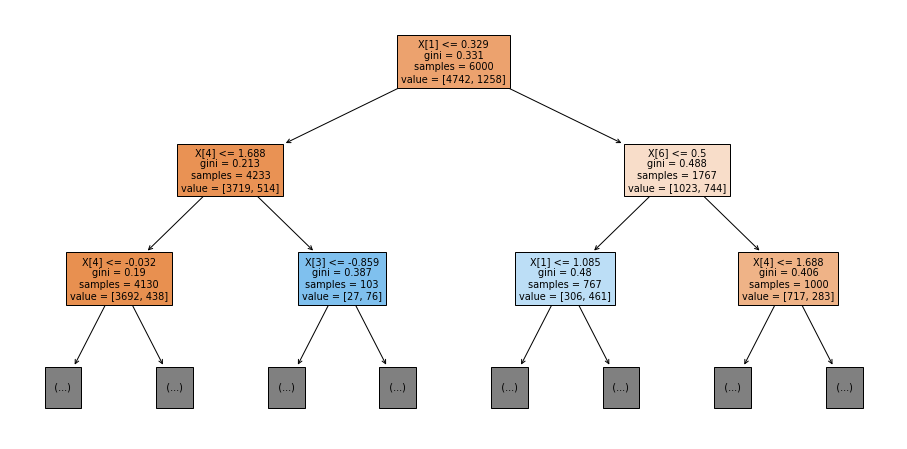

In [24]:
plt.figure(figsize=(16,8))
tree.plot_tree(model_tree, max_depth=2, filled=True)
plt.show()

Теперь рассмотрим показатель AUC-ROC

In [25]:
# для дерева решений
probabilities_tree = best_model1.predict_proba(features_valid)
probabilities_one_valid_tree = probabilities_tree[:,1]
fpr_tree,tpr_tree,thresholds = roc_curve(target_valid,probabilities_one_valid_tree)
auc_roc_tree = roc_auc_score(target_valid,probabilities_one_valid_tree)
print('AUC-ROC дерева решений:', auc_roc_tree)

AUC-ROC дерева решений: 0.8291380486044769


**Вывод:** При глубине дерева равной 7 и случайной величине равной 25 модель дерева решений дает общую точность равную 0,868, f1 равна 0,59, а AUC-ROC дерева решений равно 0.829 .

###  "Случайный лес" (Random Forest Classifier)

In [26]:
%%time

best_model2 = None
best_depth2 = 0
accuracy2 = 0
f1_2 = 0
best_est2 = 0
for est in range(1, 101):
    for depth in range(1, 20): 
        model_forest = RandomForestClassifier(random_state=25, max_depth=depth, n_estimators=est)
        model_forest.fit(features_train, target_train)
        predictions_valid_forest = model_forest.predict(features_valid)
        accuracy_forest = accuracy_score(target_valid, predictions_valid_forest)
        f1_forest = f1_score(target_valid, predictions_valid_forest)
        if f1_forest > f1_2:
            best_model2 = model_forest
            accuracy2 = accuracy_forest
            best_depth2 = depth
            f1_2 = f1_forest
            best_est2 = est

CPU times: user 9min 20s, sys: 1.98 s, total: 9min 22s
Wall time: 9min 22s


In [27]:
print('Модель:', best_model2)
print('Лучшая глубина дерева:', best_depth2)
print('Лучшее число деревьев:', best_est2)
print('Общая точность модели:', accuracy2)
print('Лучшая F1:', f1_2)

Модель: RandomForestClassifier(max_depth=16, n_estimators=41, random_state=25)
Лучшая глубина дерева: 16
Лучшее число деревьев: 41
Общая точность модели: 0.8775
Лучшая F1: 0.6293494704992436


Теперь рассмотрим показатель AUC-ROC

In [28]:
# для случайного леса
probabilities_forest = best_model2.predict_proba(features_valid)
probabilities_one_valid_forest = probabilities_forest[:,1]
fpr_forest,tpr_forest,thresholds = roc_curve(target_valid,probabilities_one_valid_forest)
auc_roc_forest = roc_auc_score(target_valid,probabilities_one_valid_forest)
print('AUC-ROC случайного леса:', auc_roc_forest)

AUC-ROC случайного леса: 0.8633247446031673


**Вывод:** При глубине дерева - 16, числе деревьев - 41, случайной величине - 25, модель случайного леса показывает лучшую общую точность равную 0,88 и лучшую f1 равную 0,63, а AUC-ROC случайного леса равно 0.863 .

### Логистическая регрессия (Logistic Regression)

In [29]:
%%time

model_logreg = LogisticRegression(random_state=25)
model_logreg.fit(features_train, target_train)
predictions_valid_logreg = model_logreg.predict(features_valid)
accuracy_logreg = accuracy_score(target_valid, predictions_valid_logreg)
f1_logreg = f1_score(target_valid, predictions_valid_forest)

CPU times: user 142 ms, sys: 252 ms, total: 394 ms
Wall time: 375 ms


In [30]:
print('Модель:', model_logreg)
print('Oбщая точность модели:', accuracy_logreg)
print('F1:', f1_logreg)

Модель: LogisticRegression(random_state=25)
Oбщая точность модели: 0.829
F1: 0.60062893081761


Теперь рассмотрим показатель AUC-ROC

In [31]:
# для логистической регрессии
probabilities_reg = model_logreg.predict_proba(features_valid)
probabilities_one_valid_reg = probabilities_reg[:,1]
fpr_log,tpr_log,thresholds = roc_curve(target_valid,probabilities_one_valid_reg)
auc_roc_reg = roc_auc_score(target_valid,probabilities_one_valid_reg)
print('AUC-ROC логистической регрессии:', auc_roc_reg)

AUC-ROC логистической регрессии: 0.8008484881238684


**Вывод:** При случайной величине равной 25, модель логистической регрессии показывает общую точность равную 0,83 и f1 равную 0,60, а AUC-ROC логистической регрессии равно 0.801 .

Теперь для моделей построим графики по AUC-ROC.

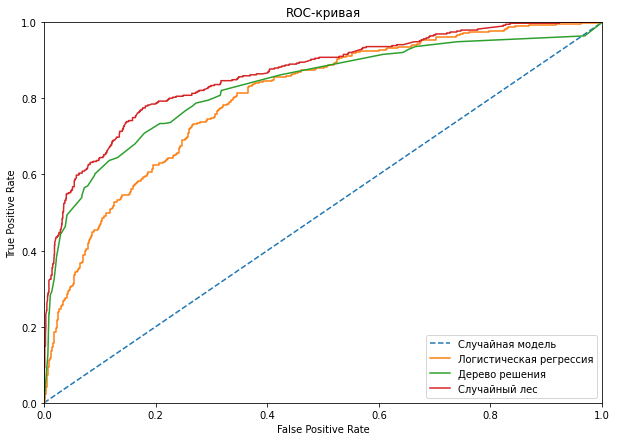

In [32]:
plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_log,tpr_log)
plt.plot(fpr_tree,tpr_tree)
plt.plot(fpr_forest,tpr_forest)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель','Логистическая регрессия','Дерево решения','Случайный лес'),loc='lower right') 
plt.show()

Как мы видим на графике лучший показатель площади под ROC-кривой у модели случайного леса.

**ИТОГ:** Наилучший показатель f1 имеет модель "Случайный лес" - 0,63, на втором месте Логистическая регрессия - 0,60, на третьем  "Дерево решений" - 0,59. При глубине дерева - 16, числе деревьев - 41, случайной величине - 25, модель случайного леса показывает лучшую общую точность равную 0,88 и лучшую f1 равную 0,63, а AUC-ROC случайного леса равно 0.863 .

## Борьба с дисбалансом

Теперь исправим дисбаланс целевого признака и попытаемся улучшить наши модели.

In [33]:
# создадим функцию для увеличения представленной класса в выборке 
def upsample(features, target, repeat, upsampled_сlass): # upsampled_сlass означает какой именно класс нужно увеличить 0 или 1
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    if upsampled_сlass == 0:
        features_upsampled = pd.concat([features_zeros]* repeat + [features_ones] )
        target_upsampled = pd.concat([target_zeros]* repeat + [target_ones] )
        features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=25)
        
    elif upsampled_сlass == 1:
        features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
        target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
        features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=25)
    else:
        features_upsampled = 0
        target_upsampled = 0  
           
    return features_upsampled, target_upsampled

In [34]:
# создадим функцию для уменьшения представленной класса в выборке 
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=25)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=25)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=25)
    
    return features_downsampled, target_downsampled

In [35]:
# т.к. 2000/8000 = 0,25, то значение fraction будет равно 0.25
features_downsampled_train, target_downsampled_train = downsample(features_train, target_train, fraction=0.25) 
print(target_downsampled_train.value_counts(normalize = 1))
print(target_downsampled_train.shape)

1    0.51473
0    0.48527
Name: Exited, dtype: float64
(2444,)


`downsample` позволил сократить данные и добиться примерно равного соотношения классов в целевом показателе

In [36]:
# применим функцию upsample и увеличим количество положительных ответов в 4 раза
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4, 1)
print(target_train_upsampled.value_counts(normalize = 0))
print(target_train_upsampled.shape)

1    5032
0    4742
Name: Exited, dtype: int64
(9774,)


`upsample` наоборот позволил увеличить данные и добиться примерно равного соотношения классов в целевом показателе

Поскольку 2444 примеров для тренировки модели это очень мало, то дальше мы будем работать с данными увеличинными с помощью функции `upsample`. Число в 9774 примера гораздо лучше подойдет для обучения моделей.

###  "Дерево решений" (Decision Tree Classifier)

In [39]:
%%time

best_model1_balanced = None
best_depth1_balanced = 0
accuracy1_balanced = 0
f1_1_balanced = 0
for depth in range(1, 20):
    model_tree_balanced = DecisionTreeClassifier(random_state=25, max_depth=depth)
    model_tree_balanced.fit(features_train_upsampled, target_train_upsampled)
    predictions_valid_tree_balanced = model_tree_balanced.predict(features_valid)
    accuracy_balanced = accuracy_score(target_valid, predictions_valid_tree_balanced)
    f1_balanced = f1_score(target_valid, predictions_valid_tree_balanced)
    if f1_balanced > f1_1_balanced:
        best_model1_balanced = model_tree_balanced
        accuracy1_balanced = accuracy_balanced
        best_depth1_balanced = depth 
        f1_1_balanced = f1_balanced

CPU times: user 687 ms, sys: 0 ns, total: 687 ms
Wall time: 695 ms


In [40]:
print('Модель:', best_model1_balanced)
print('Лучшая глубина дерева:', best_depth1_balanced)
print('Общая точность модели:', accuracy1_balanced)
print('Лучшая F1:', f1_1_balanced)

Модель: DecisionTreeClassifier(max_depth=6, random_state=25)
Лучшая глубина дерева: 6
Общая точность модели: 0.778
Лучшая F1: 0.5714285714285714


In [41]:
# для дерева решений найдем AUC-ROC
probabilities_tree_balanced = best_model1_balanced.predict_proba(features_valid)
probabilities_one_valid_tree_balanced = probabilities_tree_balanced[:,1]
fpr_tree_balanced,tpr_tree_balanced,thresholds_balanced = roc_curve(target_valid,probabilities_one_valid_tree_balanced)
auc_roc_tree_balanced = roc_auc_score(target_valid,probabilities_one_valid_tree_balanced)
print('AUC-ROC после исправления дисбаланса:', auc_roc_tree_balanced)

AUC-ROC после исправления дисбаланса: 0.8367447176130428


### "Случайный лес" (Random Forest Classifier)

In [42]:
%%time

best_model2_balanced = None
best_depth2_balanced = 0
accuracy2_balanced = 0
f1_2_balanced = 0
best_est2_balanced = 0
for est in range(1, 101):
    for depth in range(1, 20): 
        model_forest_balanced = RandomForestClassifier(random_state=25, max_depth=depth, n_estimators=est)
        model_forest_balanced.fit(features_train_upsampled, target_train_upsampled)
        predictions_valid_forest_balanced = model_forest_balanced.predict(features_valid)
        accuracy_forest_balanced = accuracy_score(target_valid, predictions_valid_forest_balanced)
        f1_forest_balanced = f1_score(target_valid, predictions_valid_forest_balanced)
        if f1_forest_balanced > f1_2_balanced:
            best_model2_balanced = model_forest_balanced
            accuracy2_balanced = accuracy_forest_balanced
            best_depth2_balanced = depth
            f1_2_balanced = f1_forest_balanced
            best_est2_balanced = est

CPU times: user 13min 30s, sys: 2.21 s, total: 13min 32s
Wall time: 13min 33s


In [43]:
print('Модель:', best_model2_balanced)
print('Лучшая глубина дерева:', best_depth2_balanced)
print('Лучшее число деревьев:', best_est2_balanced)
print('Общая точность модели:', accuracy2_balanced)
print('Лучшая F1:', f1_2_balanced)

Модель: RandomForestClassifier(max_depth=16, n_estimators=60, random_state=25)
Лучшая глубина дерева: 16
Лучшее число деревьев: 60
Общая точность модели: 0.8675
Лучшая F1: 0.6526867627785059


In [44]:
# для случайного леса найдем AUC-ROC
probabilities_forest_balanced = best_model2_balanced.predict_proba(features_valid)
probabilities_one_valid_forest_balanced = probabilities_forest_balanced[:,1]
fpr_forest_balanced,tpr_forest_balanced,thresholds_balanced = roc_curve(target_valid,probabilities_one_valid_forest_balanced)
auc_roc_forest_balanced = roc_auc_score(target_valid,probabilities_one_valid_forest_balanced)
print('AUC-ROC после исправления дисбаланса:', auc_roc_forest_balanced)

AUC-ROC после исправления дисбаланса: 0.864529604097158


### Логистическая регрессия (Logistic Regression)

In [45]:
%%time

model_logreg_balanced = LogisticRegression(random_state=25, solver='liblinear')
model_logreg_balanced.fit(features_train_upsampled, target_train_upsampled)
predictions_valid_logreg_balanced = model_logreg_balanced.predict(features_valid)
accuracy_logreg_balanced = accuracy_score(target_valid, predictions_valid_logreg_balanced)
f1_logreg_balanced = f1_score(target_valid, predictions_valid_forest_balanced)

CPU times: user 58.5 ms, sys: 92 ms, total: 150 ms
Wall time: 112 ms


In [46]:
print('Модель:', model_logreg_balanced)
print('Oбщая точность модели:', accuracy_logreg_balanced)
print('F1:', f1_logreg_balanced)

Модель: LogisticRegression(random_state=25, solver='liblinear')
Oбщая точность модели: 0.7155
F1: 0.64343163538874


In [47]:
# для логистической регрессии найдем AUC-ROC
probabilities_reg_balanced = model_logreg_balanced.predict_proba(features_valid)
probabilities_one_valid_reg_balanced = probabilities_reg_balanced[:,1]
fpr_log_balanced,tpr_log_balanced,thresholds_balanced = roc_curve(target_valid,probabilities_one_valid_reg_balanced)
auc_roc_reg_balanced = roc_auc_score(target_valid,probabilities_one_valid_reg_balanced)
print('AUC-ROC после исправления дисбаланса:', auc_roc_reg_balanced)

AUC-ROC после исправления дисбаланса: 0.8037795711145268


Построим графики ROC-кривой после устранения дисбаланса

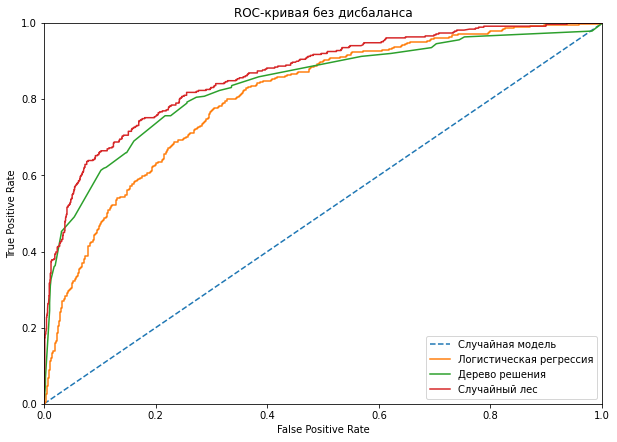

In [48]:
plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_log_balanced,tpr_log_balanced)
plt.plot(fpr_tree_balanced,tpr_tree_balanced)
plt.plot(fpr_forest_balanced,tpr_forest_balanced)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая без дисбаланса')
plt.legend(('Случайная модель','Логистическая регрессия','Дерево решения','Случайный лес'),loc='lower right') 
plt.show()

**Сведем все полученные результаты в одну таблицу**

In [49]:
resultats = pd.DataFrame([('Дерево решений', 'Accuracy', accuracy1, accuracy1_balanced),
                   ('Дерево решений', 'F1', f1_1, f1_1_balanced),
                   ('Дерево решений', 'AUC-ROC', auc_roc_tree, auc_roc_tree_balanced),
                   ('Случайный лес', 'Accuracy', accuracy2, accuracy2_balanced),
                   ('Случайный лес', 'F1', f1_2, f1_2_balanced), 
                   ('Случайный лес', 'AUC-ROC', auc_roc_forest, auc_roc_forest_balanced), 
                   ('Логистическая регрессия', 'Accuracy', accuracy_logreg, accuracy_logreg_balanced),
                   ('Логистическая регрессия', 'F1', f1_logreg, f1_logreg_balanced), 
                   ('Логистическая регрессия', 'AUC-ROC', auc_roc_reg, auc_roc_reg_balanced)],
                    columns=('Модель', 'Метрика', 'Значение с дисбалансом', 'Значение без дисбаланса'))


In [50]:
display(resultats.sort_values('Метрика'))

,Модель,Метрика,Значение с дисбалансом,Значение без дисбаланса
2,Дерево решений,AUC-ROC,0.829138,0.836745
5,Случайный лес,AUC-ROC,0.863325,0.864530
8,Логистическая регрессия,AUC-ROC,0.800848,0.803780
0,Дерево решений,Accuracy,0.868000,0.778000
3,Случайный лес,Accuracy,0.877500,0.867500
6,Логистическая регрессия,Accuracy,0.829000,0.715500
1,Дерево решений,F1,0.593846,0.571429
4,Случайный лес,F1,0.629349,0.652687
7,Логистическая регрессия,F1,0.600629,0.643432


**Вывод:** Как мы можем заметить наилучший результат из всех моделей, что с дисбалансом, что без, демонстрирует "Случайный лес". При глубине дерева - 16, числе деревьев - 60, случайной величине - 25, модель случайного леса показывает лучшую общую точность равную 0,867, лучшую f1 равную 0,652 и AUC-ROC случайного леса равный 0.864 . Устранив дисбаланс нам удалось улучшить значения данной модели по F1 до 0,652 вместо 0,629, которые были ранее. Тестировать наши данные мы будем именно на модели "Случайный лес" (Random Forest Classifier).

## Тестирование модели

In [51]:
# проведем финальное тестирование на тестовой выборке
predictions_test_forest = best_model2_balanced.predict(features_test)
result_test_forest = accuracy_score(predictions_test_forest, target_test)
f1_test_forest = f1_score(predictions_test_forest, target_test)
print('Общая точность модели на тестовых данных:', result_test_forest)
print('F1 на тестовых данных:', f1_test_forest)

Общая точность модели на тестовых данных: 0.8475
F1 на тестовых данных: 0.5883940620782726


In [52]:
probabilities_test_forest = best_model2_balanced.predict_proba(features_test)
probabilities_one_test_forest = probabilities_test_forest[:,1]
fpr_test_forest,tpr_test_forest,thresholds_test_forest = roc_curve(target_test, probabilities_one_test_forest)
print('AUC-ROC на тестовой выборке:', roc_auc_score(target_test, probabilities_one_test_forest))

AUC-ROC на тестовой выборке: 0.8399064042874319


На тестовых данных мы получили желаемый результат. F1 с округлением достигла показателя 0,59. Что сравнительно ниже, чем на обучающей выборке.  

Проверим нашу модель на адекватность и создадим константную модель.

In [53]:
target_predict_constant = pd.Series([0]*len(target_test))
target_predict_constant.value_counts()

0    2000
dtype: int64

In [54]:
# сравним показатель общей точности (accuracy) константной модели и финальной
print('Accuracy константой модели:', accuracy_score(target_valid, target_predict_constant))
print('Accuracy финальной модели:', accuracy_score(target_test, predictions_test_forest))

Accuracy константой модели: 0.8045
Accuracy финальной модели: 0.8475


Как мы можем заметить точность финальной модели выше чем точность константной. Поэтому модель можно считать адекватной.

In [55]:
print('Recall финальной модели:', recall_score(target_test, predictions_test_forest))

Recall финальной модели: 0.5618556701030928


**Вывод:** Нам удалось создать адекватную модель машинного обучения, которая на новых данных достигает приемлемого результата в своей точности и которая верно предсказывает 56% истинных значений.

# Общий вывод

_Изучив первоначальные данные из 10000 строк и 14 столбцов, мы увидели, что в них присутствуют пропуски, лишняя информация, дисбаланс классов в целевом признаке. Исправив все это мы смогли построить несколько моделей, лучшей из которых оказалась модель "Случайный лес". При глубине дерева - 16, числе деревьев - 60, случайной величине - 25, модель случайного леса показывает лучшую общую точность равную 0,867, лучшую f1 равную 0,652 и AUC-ROC случайного леса равный 0.864 . Данную модель можно рекомендовать  «Бета-Банку» для прогноза оттока клиентов. В 2-х из 3-х случаев данная модель поможет банку правильно определить перестанет ли человек быть клиентом банка или же нет. В зависимости от ответа можно будет применять соответствующие меры, в т.ч. маркетингового плана, чтобы удержать как можно больше клиентов._